In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

In [4]:
lstm = nn.LSTM(3, 3)


inputs = [torch.randn(1, 3) for _ in range(5)]
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))
for i in inputs:
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)


tensor([[[-0.1728, -0.4397,  0.1527]],

        [[-0.1477, -0.1548,  0.2824]],

        [[-0.1569, -0.1602,  0.2466]],

        [[ 0.0118,  0.0166,  0.4544]],

        [[-0.0297, -0.0051,  0.3407]]], grad_fn=<StackBackward>)
(tensor([[[-0.0297, -0.0051,  0.3407]]], grad_fn=<StackBackward>), tensor([[[-0.0733, -0.0106,  0.7060]]], grad_fn=<StackBackward>))


In [223]:
class LSTMController(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, num_layers):
        super(LSTMController, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_layers = num_layers
                        
        self.lstm = nn.LSTM(input_size=self.num_inputs, hidden_size=self.num_outputs, num_layers=self.num_layers, bias=True)
        
        self.h_bias = nn.Parameter(torch.randn(self.num_layers, 1, self.num_outputs) * 0.05)
        self.c_bias = nn.Parameter(torch.randn(self.num_layers, 1, self.num_outputs) * 0.05)
                
        self.reset()
        
    def reset(self):
        for param in self.lstm.parameters():
            if param.dim() == 1:
                nn.init.constant_(param, 0)
            else:
                std = 5 / np.sqrt(self.num_inputs + self.num_outputs)
                nn.init.uniform_(param, -std, std)
    
    def size(self):
        return (self.num_inputs(), self.num_outputs())
    
    def create_new_state(self, batch_size):
        lstm_h = self.h_bias.clone().repeat(1, batch_size, 1)
        lstm_c = self.c_bias.clone().repeat(1, batch_size, 1)
        return lstm_h, lstm_c
    
    def forward(self, inputs, prev_state):
        outputs, new_state = self.lstm(inputs.unsqueeze(0), prev_state)
        return outputs.squeeze(0), new_state
        
    
def convolve_circularly(w, s):
        t = torch.cat([w[-1:], w, w[:1]])
        return F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(-1)
    
class MemoryBlock(nn.Module):
    
    def __init__(self, num_cells, cell_size):
        super(MemoryBlock, self).__init__()
        self.num_cells = num_cells
        self.cell_size = cell_size
        self.register_buffer('mem_bias', torch.Tensor(num_cells, cell_size))
        nn.init.constant_(self.mem_bias, 1e-6)
               
    def size(self):
        return self.num_cells, self.cell_size
    
    def reset(self, batch_size):
        self.batch_size = batch_size
        self.memory = self.mem_bias.clone().repeat(batch_size, 1, 1)
        
    def read(self, read_weight):
        return torch.matmul(read_weight.unsqueeze(1), self.memory).squeeze(1)
    
    def write(self, write_vec, erase_weight, add_vec):
        self.memory = self.memory * (1 - torch.matmul(write_vec.unsqueeze(-1), erase_weight.unsqueeze(1))) + torch.matmul(write_vec.unsqueeze(-1), add_vec.unsqueeze(1))
        
    def address(self, key, key_weight, gating_factor, shift_weight, sharpening_factor, prev_weight):
        content_weight = self._content_addressing(key, key_weight)
        interp_weight = self._interpolate(prev_weight, content_weight, gating_factor)
        rotated_weight = self._shift(interp_weight, shift_weight)
        final_weight = self._sharpen(rotated_weight, sharpening_factor)
        return final_weight
        
        
    def _content_addressing(self, key, key_weight):
        key = key.view(self.batch_size, 1, -1)
        return F.softmax(key_weight * F.cosine_similarity(self.memory + 1e-16, key + 1e-16, dim=-1), dim=1)
    
    def _interpolate(self, prev_weight, content_weight, gating_factor):
        return gating_factor * content_weight + (1 - gating_factor) * prev_weight
    
    def _shift(self, interp_weight, shift_weight):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        result = torch.zeros(interp_weight.size(), device=device)
        for batch_num in range(self.batch_size):
            result[batch_num] = convolve_circularly(interp_weight[batch_num], shift_weight[batch_num])
        return result
    
    def _sharpen(self, rotated_weight, sharpening_factor):
        sharpened_weight = rotated_weight ** sharpening_factor
        return torch.div(rotated_weight, torch.sum(sharpened_weight, dim=1).view(-1, 1) + 1e-16)
    
        

In [224]:
def split_cols(mat, lengths):
    cum_lengths = np.cumsum([0] + lengths)
    results = []
    for s, e in zip(cum_lengths[:-1], cum_lengths[1:]):
        results += [mat[:, s:e]]
    return results

class GenericHead(nn.Module):
    
    def __init__(self, memory, controller_size):
        super(GenericHead, self).__init__()
        self.memory = memory
        self.num_cells, self.cell_size = self.memory.size()
        self.controller_size = controller_size
                
    def _address_memory(self, key, key_weight, gating_factor, shift_weight, sharpening_factor, prev_weight):
        key = key.clone()
        key_weight = F.softplus(key_weight)
        gating_factor = F.sigmoid(gating_factor)
        shift_weight = F.softmax(shift_weight, dim=0)
        sharpening_factor = 1 + F.softplus(sharpening_factor)
        
        return self.memory.address(key, key_weight, gating_factor, shift_weight, sharpening_factor, prev_weight)
    
    
class ReadHead(GenericHead):
        
    def __init__(self, memory, controller_size):
        super(ReadHead, self).__init__(memory, controller_size)

        self.read_lengths = [self.cell_size, 1, 1, 3, 1]
        self.read_input = nn.Linear(controller_size, sum(self.read_lengths))
        self.reset()
        
    def create_new_state(self, batch_size):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        return torch.zeros(batch_size, self.num_cells, device=device)

    def reset(self):
        nn.init.xavier_uniform_(self.read_input.weight, gain=1.4)
        nn.init.normal_(self.read_input.bias, std=0.01)

    def forward(self, embeddings, prev_weight):
        read_params = self.read_input(embeddings)

        key, key_weight, gating_factor, shift_weight, sharpening_factor = split_cols(read_params, self.read_lengths)

        address_weight = self._address_memory(key, key_weight, gating_factor, shift_weight, sharpening_factor, prev_weight)
        return self.memory.read(address_weight), address_weight

class WriteHead(GenericHead):

    def __init__(self, memory, controller_size):
        super(WriteHead, self).__init__(memory, controller_size)

        self.write_lengths = [self.cell_size, 1, 1, 3, 1, self.cell_size, self.cell_size]
        self.write_input = nn.Linear(controller_size, sum(self.write_lengths))
        self.reset()

    def reset(self):
        nn.init.xavier_uniform_(self.write_input.weight, gain=1.4)
        nn.init.normal_(self.write_input.bias, std=0.01)
        
    def create_new_state(self, batch_size):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        return torch.zeros(batch_size, self.num_cells, device=device)

    def forward(self, embeddings, prev_weight):
        write_params = self.write_input(embeddings)

        key, key_weight, gating_factor, shift_weight, sharpening_factor, error_weight, add_vector = split_cols(write_params, self.write_lengths)

        error_weight = F.sigmoid(error_weight)

        address_weight = self._address_memory(key, key_weight, gating_factor, shift_weight, sharpening_factor, prev_weight)
        self.memory.write(address_weight, error_weight, add_vector)
        
        return address_weight


In [225]:
class NeuralTuringMachine(nn.Module):
    def __init__(self, num_inputs, num_outputs, controller_size, num_cells, cell_size, num_read_heads, num_write_heads):
        super(NeuralTuringMachine, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.controller_size = controller_size
        self.num_cells = num_cells
        self.cell_size = cell_size
        self.num_read_heads = num_read_heads
        self.num_write_heads = num_write_heads
        
        self.memory = MemoryBlock(num_cells, cell_size)
        self.controller = LSTMController(num_inputs + cell_size * num_read_heads, controller_size[0], controller_size[1])
        self.read_heads = nn.ModuleList([])
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.init_read = []
        for i in range(num_read_heads):
            self.init_read += [torch.randn(1, cell_size, device=device) * 0.01]
            self.register_buffer("read_bias{}".format(i + 1), self.init_read[i].data)            
            self.read_heads += [ReadHead(self.memory, self.controller_size[0])]
                    
        self.write_heads = nn.ModuleList([])
        for i in range(num_write_heads):
            self.write_heads += [WriteHead(self.memory, self.controller_size[0])]
        
        self.output_layer = nn.Linear(self.controller_size[0] + num_read_heads * self.cell_size, self.num_outputs)
        self.reset()
        
    def reset(self):
        nn.init.xavier_uniform_(self.output_layer.weight, gain=1)
        nn.init.normal_(self.output_layer.bias, std=0.01)
        
    def create_new_state(self, batch_size):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        init_read = [r.clone().repeat(batch_size, 1) for r in self.init_read]
        controller_state = self.controller.create_new_state(batch_size)
        head_states = [head.create_new_state(batch_size) for head in self.read_heads] + [head.create_new_state(batch_size) for head in self.write_heads]
            
        return init_read, controller_state, head_states
    
    def init_sequence(self, batch_size):
        self.batch_size = batch_size
        self.memory.reset(batch_size)
        self.prev_state = self.create_new_state(batch_size)

    def forward(self, inputs=None):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if inputs is None:
            inputs = torch.zeros(self.batch_size, self.num_inputs, device=device)
            
        prev_reads, prev_controller_state, prev_head_states = self.prev_state
        controller_output, controller_state = self.controller(torch.cat([inputs] + prev_reads, dim=1), prev_controller_state)
        
        reads = []
        head_states = []
        
        for read_head, prev_head_state in zip(self.read_heads, prev_head_states):
            r, head_state = read_head(controller_output, prev_head_state)
            reads += [r]
            head_states += [head_state]
            
        for write_head, prev_head_state in zip(self.write_heads, prev_head_states):
            head_state = write_head(controller_output, prev_head_state)
            head_states += [head_state]
        
        outputs = torch.sigmoid(self.output_layer(torch.cat([controller_output] + reads, dim=1)))
        self.prev_state = (reads, controller_state, head_states)
        
        return outputs, self.prev_state
        

In [244]:
def get_copy_batch(batch_size, seq_len, num_bits):            
        seq = torch.from_numpy(np.random.binomial(1, 0.5, (seq_len, batch_size, num_bits)))
        input_seq = torch.zeros(seq_len + 1, batch_size, num_bits + 1)
        input_seq[:seq_len, :, :num_bits] = seq
        input_seq[seq_len, :, num_bits] = 1.0
        target_seq = seq.clone()

        return input_seq.float(), target_seq.float()
        
def clip_grads(ntm):
    parameters = list(filter(lambda p: p.grad is not None, ntm.parameters()))
    for param in parameters:
        param.grad.data.clamp_(-10, 10)

def train_batch(ntm, criterion, optimizer, input_batch, target_batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    optimizer.zero_grad()
    input_seq_len = input_batch.size(0)
    output_seq_len, batch_size, _ = target_batch.size()
    
    ntm.init_sequence(batch_size)
    
    for i in range(input_seq_len):
        ntm(input_batch[i])
        
    output_batch = torch.zeros(target_batch.size(), device=device)
    for i in range(output_seq_len):
        output_batch[i], _ = ntm()
        
    batch_loss = criterion(output_batch, target_batch)
    batch_loss.backward()
    clip_grads(ntm)
    optimizer.step()
    
    output_batch_bin = output_batch.clone().data.round_()    
    
    batch_cost = torch.sum(torch.abs(output_batch_bin - target_batch.data))
    
    return batch_loss.item(), batch_cost.item() / batch_size

def evaluate(ntm, criterion, input_batch, target_batch):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_seq_len = input_batch.size(0)
    output_seq_len, batch_size, _ = target_batch.size()
    
    ntm.init_sequence(batch_size)
    
    states = []
    for i in range(input_seq_len):
        _, state = ntm(input_batch[i])
        states += [state]
        
    output_batch = torch.zeros(target_batch.size(), device=device)
    for i in range(output_seq_len):
        output_batch[i], state = ntm()
        states += [state]
        
    batch_loss = criterion(output_batch, target_batch)
    
    output_batch_bin = output_batch.clone().data.round_()    
    
    batch_cost = torch.sum(torch.abs(output_batch_bin - target_batch.data))
    
    result = {
        'loss': batch_loss.data.item(),
        'cost': batch_cost / batch_size,
        'output_batch': output_batch,
        'output_batch_bin': output_batch_bin,
        'states': states
    }
        
    return result

In [256]:
import matplotlib.pyplot as plt
import time

controller_width = 100
controller_depth = 1
num_read_heads = 1
num_write_heads = 1
num_bits = 8
seq_len_min = 1
seq_len_max = 20
num_cells = 128
cell_size = 8
num_batches = 50000
batch_size = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntm = NeuralTuringMachine(num_bits + 1, num_bits, (controller_width, controller_depth), num_cells, cell_size, num_read_heads, num_write_heads)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(), momentum=0.9, alpha=0.95, lr=1e-4)
ntm.to(device)
criterion.to(device)

losses = np.zeros(num_batches, dtype=float)
costs = np.zeros(num_batches, dtype=float)

Epoch #1: 0.28 seconds
Epoch #2: 2.3e+03 seconds
Epoch #3: 1.6e+04 seconds
Epoch #4: 1.8e+04 seconds


KeyboardInterrupt: 

In [273]:
tic = time.time()

for batch_num in range(30000, num_batches):
    batch = get_copy_batch(batch_size, np.random.randint(seq_len_min, seq_len_max), num_bits)
    input_batch, target_batch = batch[0].to(device), batch[1].to(device)
    losses[batch_num], costs[batch_num] = train_batch(ntm, criterion, optimizer, input_batch, target_batch)
    if batch_num % 5000 == 0:
        toc = time.time()
        print("Epoch #{}: {:.2} seconds".format(batch_num // 5000 + 1, toc - tic))
    
toc = time.time()
    

Epoch #7: 0.59 seconds
Epoch #8: 2.3e+03 seconds
Epoch #9: 4.6e+03 seconds
Epoch #10: 1.4e+04 seconds


Text(0.5, 1.0, 'Time Elapsed: 15794.602104663849 Seconds')

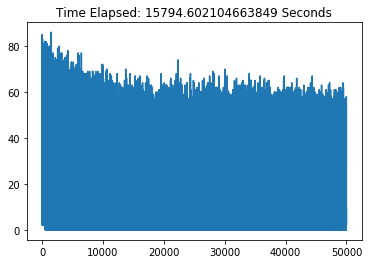

In [274]:
plt.plot(costs)
plt.title('Time Elapsed: {} Seconds'.format(toc - tic))

In [292]:
batch = get_copy_batch(batch_size, 6, num_bits)
input_batch, target_batch = batch[0].to(device), batch[1].to(device)
result = evaluate(ntm, criterion, input_batch, target_batch)

print(result['cost'].cpu().numpy())
print(input_batch.cpu().numpy().squeeze())
print(result['output_batch_bin'].cpu().numpy().squeeze())


plt.imshow(np.hstack((input_batch.cpu().numpy().squeeze()[:,0:8].T, result['output_batch_bin'].cpu().numpy().squeeze().T)))

RuntimeError: CUDA error: unknown error

In [304]:
def make_checkpoint(model, optimizer, losses, costs, task_name, batch_num):
    torch.save({'batch_num': batch_num, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'losses': losses, 'costs': costs }, 'ntm-{}task-{}.pt'.format(task_name, batch_num))
    
make_checkpoint(ntm, optimizer, losses, costs, 'copy', 50000)

RuntimeError: cuda runtime error (30) : unknown error at C:\w\1\s\tmp_conda_3.7_044431\conda\conda-bld\pytorch_1556686009173\work\torch/csrc/generic/serialization.cpp:23

In [299]:
'ntm-{}task-{}.pt'.format('copy', 50000)

'ntm-copytask-50000.pt'